In [1]:
# DPD Simulation in 2D
import numpy as np
import matplotlib.pyplot as plt

# Constants
L = 15.0
rc = 1.0
rho = 4.0
N = int(rho * L * L)
dt = 0.01
steps = 1000
kBT = 0.1111
sigma = 1.0
gamma = 4.5

np.random.seed(42)

In [2]:
# Particle class
class Particle:
    def __init__(self, position, velocity, ptype, fixed=False):
        self.r = np.array(position)
        self.v = np.array(velocity)
        self.f = np.zeros(2)
        self.ptype = ptype
        self.fixed = fixed

# Bond class
class Bond:
    def __init__(self, i, j, r0, k):
        self.i = i
        self.j = j
        self.r0 = r0
        self.k = k

# Cell list for neighbor search
class CellList:
    def __init__(self, rc, L):
        self.rc = rc
        self.L = L
        self.n_cells = int(L / rc)
        self.cells = [[] for _ in range(self.n_cells ** 2)]

    def get_cell_index(self, pos):
        ix = int(pos[0] / self.rc) % self.n_cells
        iy = int(pos[1] / self.rc) % self.n_cells
        return ix + self.n_cells * iy

    def build(self, particles):
        self.cells = [[] for _ in range(self.n_cells ** 2)]
        for i, p in enumerate(particles):
            idx = self.get_cell_index(p.r)
            self.cells[idx].append(i)

    def neighbors(self, idx, particles):
        p = particles[idx]
        ix = int(p.r[0] / self.rc) % self.n_cells
        iy = int(p.r[1] / self.rc) % self.n_cells
        neigh = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                cx = (ix + dx) % self.n_cells
                cy = (iy + dy) % self.n_cells
                cell_idx = cx + self.n_cells * cy
                for j in self.cells[cell_idx]:
                    if j != idx:
                        neigh.append(j)
        return neigh

In [3]:
# Force calculations (DPD only, no bonds here)
def compute_forces(particles, cell_list):
    cell_list.build(particles)
    for p in particles:
        p.f[:] = 0.0
    for i, pi in enumerate(particles):
        for j in cell_list.neighbors(i, particles):
            pj = particles[j]
            rij = pi.r - pj.r
            rij -= L * np.round(rij / L)
            r = np.linalg.norm(rij)
            if r < rc and r > 1e-12:
                eij = rij / r
                vij = pi.v - pj.v

                a = aij.get((pi.ptype, pj.ptype), 0.0)
                FC = a * (1 - r / rc) * eij
                wD = (1 - r / rc) ** 2
                FD = -gamma * wD * np.dot(vij, eij) * eij
                wR = (1 - r / rc)
                rand = np.random.normal(0, 1)
                FR = sigma * wR * rand * eij / np.sqrt(dt)
                F = FC + FD + FR

                pi.f += F
                pj.f -= F


In [4]:
# Velocity-Verlet integrator
def velocity_verlet(particles):
    for p in particles:
        if not p.fixed:
            p.v += 0.5 * dt * p.f
            p.r += dt * p.v
            p.r %= L
    compute_forces(particles, cell_list)
    for p in particles:
        if not p.fixed:
            p.v += 0.5 * dt * p.f

In [5]:
# Initialize particles
particles = [Particle(position=L * np.random.rand(2), velocity=np.zeros(2), ptype='F') for _ in range(N)]

# A simple aij matrix for single-type fluid test
aij = {('F', 'F'): 25.0}

# Build cell list
cell_list = CellList(rc, L)

# Main loop
compute_forces(particles, cell_list)
temps = []
for step in range(steps):
    velocity_verlet(particles)
    # Measure temperature
    v2 = np.sum([np.dot(p.v, p.v) for p in particles if not p.fixed]) / (2 * len(particles))
    temps.append(v2)
    if step % 100 == 0:
        print(f"Step {step}: T = {v2:.4f}")


Step 0: T = 0.2484
Step 100: T = 0.3346
Step 200: T = 0.1815
Step 300: T = 0.1393
Step 400: T = 0.1289
Step 500: T = 0.1178
Step 600: T = 0.1203
Step 700: T = 0.1130
Step 800: T = 0.1157
Step 900: T = 0.1114


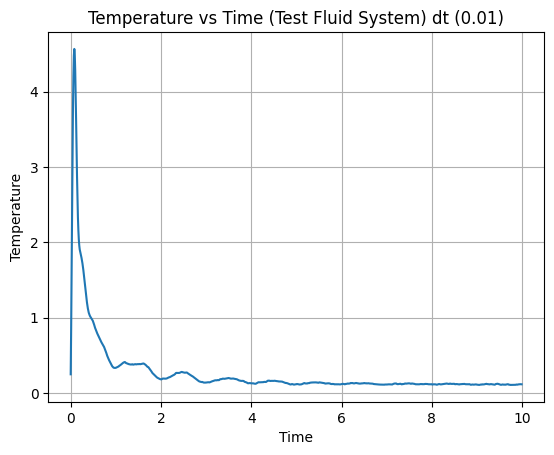

In [7]:
# Plot temperature over time
plt.plot(np.arange(steps) * dt, temps)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature vs Time (Test Fluid System) dt (0.01)")
plt.grid(True)
plt.show()


In [8]:
dt = 0.02
# Initialize particles
particles = [Particle(position=L * np.random.rand(2), velocity=np.zeros(2), ptype='F') for _ in range(N)]

# A simple aij matrix for single-type fluid test
aij = {('F', 'F'): 25.0}

# Build cell list
cell_list = CellList(rc, L)

# Main loop
compute_forces(particles, cell_list)
temps = []
for step in range(steps):
    velocity_verlet(particles)
    # Measure temperature
    v2 = np.sum([np.dot(p.v, p.v) for p in particles if not p.fixed]) / (2 * len(particles))
    temps.append(v2)
    if step % 100 == 0:
        print(f"Step {step}: T = {v2:.4f}")

Step 0: T = 0.9304
Step 100: T = 0.1597
Step 200: T = 0.1247
Step 300: T = 0.1239
Step 400: T = 0.1137
Step 500: T = 0.1181
Step 600: T = 0.1130
Step 700: T = 0.1143
Step 800: T = 0.1142
Step 900: T = 0.1100


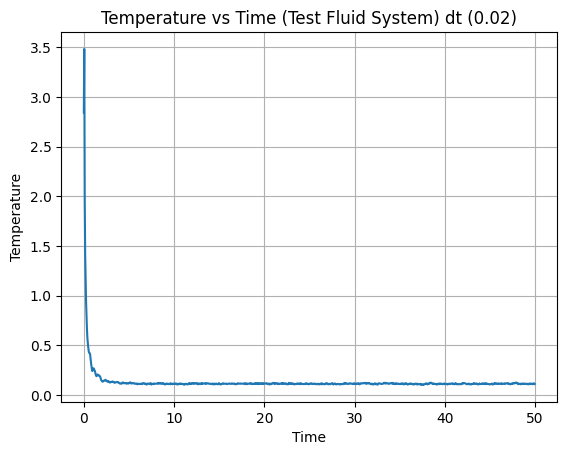

In [12]:
# Plot temperature over time
plt.plot(np.arange(steps) * dt, temps)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature vs Time (Test Fluid System) dt (0.02)")
plt.grid(True)
plt.show()

In [16]:
dt = 0.05
# Initialize particles
particles = [Particle(position=L * np.random.rand(2), velocity=np.zeros(2), ptype='F') for _ in range(N)]

# A simple aij matrix for single-type fluid test
aij = {('F', 'F'): 25.0}

# Build cell list
cell_list = CellList(rc, L)

# Main loop
compute_forces(particles, cell_list)
temps = []
for step in range(steps):
    velocity_verlet(particles)
    # Measure temperature
    v2 = np.sum([np.dot(p.v, p.v) for p in particles if not p.fixed]) / (2 * len(particles))
    temps.append(v2)
    if step % 100 == 0:
        print(f"Step {step}: T = {v2:.4f}")

Step 0: T = 2.8691
Step 100: T = 0.1177
Step 200: T = 0.1054
Step 300: T = 0.1091
Step 400: T = 0.1071
Step 500: T = 0.1159
Step 600: T = 0.1198
Step 700: T = 0.1089
Step 800: T = 0.1084
Step 900: T = 0.1209


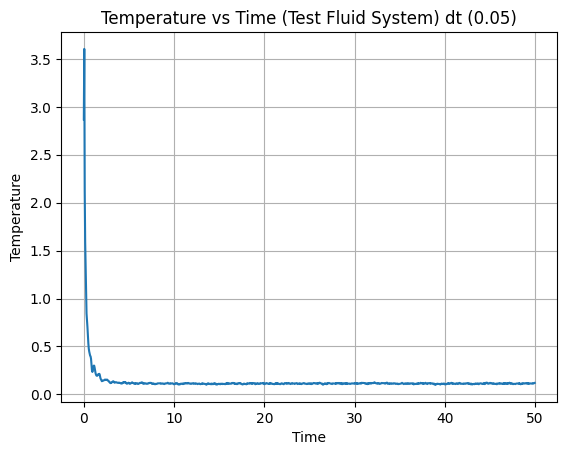

In [17]:
# Plot temperature over time
plt.plot(np.arange(steps) * dt, temps)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature vs Time (Test Fluid System) dt (0.05)")
plt.grid(True)
plt.show()